# Make Beam for BeamFour

Generate that particular RAY file used by BeamFour.
The convergent beam is generated.
In this version inclined incident beam is implemented.

The output file is generated using implemented function based on python formatted string.

- author : Sylvie Dagoret-Campagne
- creation date : August 26th 2020


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools

In [2]:
from astropy import units as u
from astropy.coordinates import Angle

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# configuration of the Beam

In [4]:
root_filename="Beam4_Rayfile_"

In [5]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y

In [6]:
Wavelength=np.arange(350,1101,50)
WL=(Wavelength).astype(int)
NWL=len(WL)

In [7]:
NWL

16

In [8]:
WL

array([ 350,  400,  450,  500,  550,  600,  650,  700,  750,  800,  850,
        900,  950, 1000, 1050, 1100])

In [9]:
theta_x=60*u.arcmin # target offset in arcmin
#theta_x=0
theta_y=10*u.arcmin # angle in arcmin 

In [10]:
theta_x_num=int(theta_x*100/u.arcmin)
theta_y_num=int(theta_y*100/u.arcmin)

In [11]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [12]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [13]:
Beam4_Rayfile_EXCEL="Beam4_Rayfile_{:d}_nw{:d}_thx{}_thy{}.xlsx".format(NBEAM,NWL,theta_x_str,theta_y_str)
Beam4_Rayfile_RAY="Beam4_Rayfile_{:d}_nw{:d}_thx{}_thy{}.RAY".format(NBEAM,NWL,theta_x_str,theta_y_str)

In [14]:
Beam4_Rayfile_EXCEL

'Beam4_Rayfile_121_nw16_thxp6000_thyp1000.xlsx'

In [15]:
Beam4_Rayfile_RAY

'Beam4_Rayfile_121_nw16_thxp6000_thyp1000.RAY'

# configuration of Telescope

In [16]:
Tel_Focal_Length=21.6# m : Focal length of the telescope
Tel_Diameter=1.2# m : Diameter of the telescope  

In [17]:
Tel_Fnum=Tel_Focal_Length/Tel_Diameter

In [18]:
print("Aperture/D =  {} ".format(Tel_Fnum))

Aperture/D =  18.000000000000004 


### distance between the entrance plane and the focal plane

In [19]:
d=200  # here set to be in mm (the BeamFour length units)

# Functions

In [20]:
def set_aspect_equal_3d(ax):
    """Fix equal aspect bug for 3D plots."""

    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)

    plot_radius = max([abs(lim - mean_)
                       for lims, mean_ in ((xlim, xmean),
                                           (ylim, ymean),
                                           (zlim, zmean))
                       for lim in lims])

    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

In [21]:
def EntranceBeamPopulation(nbeamx,nbeamy,f,D,d):
    """
    EntranceBeamPopulation(nbeamx,nbeamy,thetax,thetay,f,D,d)
    
    input arguments :
      - nbeamx : number of beam along x (should be odd, by example 11)
      - nbeamy : number of beam along y (should be odd, by example 11)
      - thetax : central beam angle along x in radian 
      - f : telescope focal length in m
      - D : telescope diameter in m
      - d : distance entrance (beam start) to focal plane. the unit of d is what we want
      
      
    output arguments :
      - return X,Y coordinate of beams relative to central beam (position (0,0)) in same unit as d
    """
    
    numberOfRows = nbeamx*nbeamy
    
    X=np.linspace(-D*d/2/f,D*d/2/f,nbeamx)
    Y=np.linspace(-D*d/2/f,D*d/2/f,nbeamy)
    
    # need to alloc memory for the dataframe
    df=pd.DataFrame(index=np.arange(0, numberOfRows),columns=['id','nx', 'ny', 'X0','Y0'])
    
    idx=0
    for ny in np.arange(len(Y)):
        for nx in np.arange(len(X)):         
            df.iloc[idx]= [idx+1, nx,ny,X[nx],Y[ny]]
            idx+=1
            
    df["Z0"] = -d
    
    return df
    

In [22]:
def ComputeAngles(df_in,alphax,alphay,d):
    """
    ComputeAngles(df_in,thetax,thetay,d)
    
    * input argument
      - df_in
      - thetax,thetay angles in radians
      - d : distance entrance -focal point
      
    * output argument
      -df
    
    
    """
    tan_alphax_0=np.tan(alphax)
    tan_alphay_0=np.tan(alphay)
    x=np.asarray(df_in["X0"].values).astype(np.float64)
    y=np.asarray(df_in["Y0"].values).astype(np.float64)
    
    tan_alphax=np.array(tan_alphax_0-x/d)
    tan_alphay=np.array(tan_alphay_0-y/d)
    
    
    Uz=1./(np.sqrt(1.+tan_alphax**2+tan_alphay**2))
    Ux=tan_alphax*Uz
    Uy=tan_alphay*Uz
    
    df=df_in
    df["U0"]=Ux
    df["V0"]=Uy
    df["W0"]=Uz
    
    return df
    
    
    

In [23]:
def SimulateSquareBeam(nbeamx,nbeamy,thetax,thetay,f,D,d):
    """
    SimulateSquareBeam(nbeamx,nbeamy,thetax,thetay,f,D,d)
    
    input arguments :
      - nbeamx : number of beam along x (should be odd, by example 11)
      - nbeamy : number of beam along y (should be odd, by example 11)
      - thetax : central beam angle along x in radian 
      - f : telescope focal length in m
      - D : telescope diameter in m
      - d : distance entrance (beam start) to focal plane   
    """

# compute

## repartition of beams at entrance

In [24]:
df=EntranceBeamPopulation(NBEAM_X,NBEAM_Y,Tel_Focal_Length,Tel_Diameter,d)

In [25]:
len(df)

121

In [26]:
df

,id,nx,ny,X0,Y0,Z0
0,1,0,0,-5.55556,-5.55556,-200
1,2,1,0,-4.44444,-5.55556,-200
2,3,2,0,-3.33333,-5.55556,-200
3,4,3,0,-2.22222,-5.55556,-200
4,5,4,0,-1.11111,-5.55556,-200
...,...,...,...,...,...,...
116,117,6,10,1.11111,5.55556,-200
117,118,7,10,2.22222,5.55556,-200
118,119,8,10,3.33333,5.55556,-200
119,120,9,10,4.44444,5.55556,-200


## Orientation of beams

In [27]:
alpha_x=-Angle(theta_x)
alpha_y=-Angle(theta_y)

In [28]:
df=ComputeAngles(df,alpha_x.radian,alpha_y.radian,d)

In [29]:
df

,id,nx,ny,X0,Y0,Z0,U0,V0,W0
0,1,0,0,-5.55556,-5.55556,-200,0.010319,0.024860,0.999638
1,2,1,0,-4.44444,-5.55556,-200,0.004766,0.024861,0.999680
2,3,2,0,-3.33333,-5.55556,-200,-0.000788,0.024861,0.999691
3,4,3,0,-2.22222,-5.55556,-200,-0.006342,0.024861,0.999671
4,5,4,0,-1.11111,-5.55556,-200,-0.011895,0.024859,0.999620
...,...,...,...,...,...,...,...,...,...
116,117,6,10,1.11111,5.55556,-200,-0.022994,-0.030664,0.999265
117,118,7,10,2.22222,5.55556,-200,-0.028541,-0.030660,0.999122
118,119,8,10,3.33333,5.55556,-200,-0.034086,-0.030654,0.998949
119,120,9,10,4.44444,5.55556,-200,-0.039627,-0.030648,0.998744


### check the calculation of directions 

In [30]:
# compute the norm
df.apply(lambda x: np.sqrt(x.U0**2+x.V0**2+x.W0**2), axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
116    1.0
117    1.0
118    1.0
119    1.0
120    1.0
Length: 121, dtype: float64

### beams at entrance

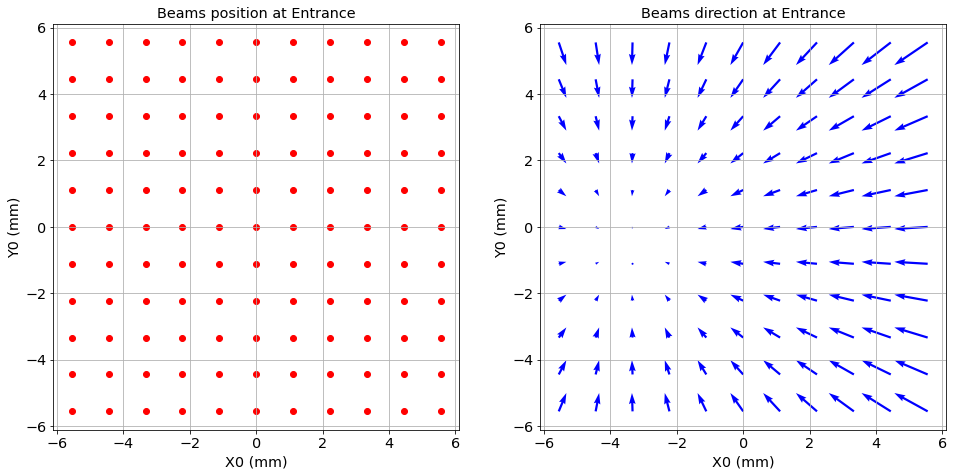

In [31]:
fig=plt.figure(figsize=(16,8))

ax=fig.add_subplot(121)
ax.scatter(df["X0"].values,df["Y0"].values,color="r")
ax.grid()
ax.set_xlabel("X0 (mm)")
ax.set_ylabel("Y0 (mm)")
ax.set_title("Beams position at Entrance")
ax.set_aspect('equal')


ax=fig.add_subplot(122)
X=np.asarray(df["X0"].values).astype(np.float64)
Y=np.asarray(df["Y0"].values).astype(np.float64)
U=np.asarray(df["U0"].values).astype(np.float64)
V=np.asarray(df["V0"].values).astype(np.float64)

ax.quiver(X,Y,U,V,color="b")
ax.grid()
ax.set_xlabel("X0 (mm)")
ax.set_ylabel("Y0 (mm)")
ax.set_title("Beams direction at Entrance")
ax.set_aspect('equal')


## Compute focal point position ad Z=d

In [32]:
df["X1"]=df.apply(lambda x: (x.X0+d*x.U0/x.W0), axis=1)
df["Y1"]=df.apply(lambda x: (x.Y0+d*x.V0/x.W0), axis=1)
df["Z1"] = 0

In [33]:
df

,id,nx,ny,X0,Y0,Z0,U0,V0,W0,X1,Y1,Z1
0,1,0,0,-5.55556,-5.55556,-200,0.010319,0.024860,0.999638,-3.491013,-0.581778,0
1,2,1,0,-4.44444,-5.55556,-200,0.004766,0.024861,0.999680,-3.491013,-0.581778,0
2,3,2,0,-3.33333,-5.55556,-200,-0.000788,0.024861,0.999691,-3.491013,-0.581778,0
3,4,3,0,-2.22222,-5.55556,-200,-0.006342,0.024861,0.999671,-3.491013,-0.581778,0
4,5,4,0,-1.11111,-5.55556,-200,-0.011895,0.024859,0.999620,-3.491013,-0.581778,0
...,...,...,...,...,...,...,...,...,...,...,...,...
116,117,6,10,1.11111,5.55556,-200,-0.022994,-0.030664,0.999265,-3.491013,-0.581778,0
117,118,7,10,2.22222,5.55556,-200,-0.028541,-0.030660,0.999122,-3.491013,-0.581778,0
118,119,8,10,3.33333,5.55556,-200,-0.034086,-0.030654,0.998949,-3.491013,-0.581778,0
119,120,9,10,4.44444,5.55556,-200,-0.039627,-0.030648,0.998744,-3.491013,-0.581778,0



# Plot 3D

In [34]:
X0=np.asarray(df["X0"].values).astype(np.float64)
Y0=np.asarray(df["Y0"].values).astype(np.float64)
Z0=np.asarray(df["Z0"].values).astype(np.float64)

In [35]:
U0=np.asarray(df["U0"].values).astype(np.float64)
V0=np.asarray(df["V0"].values).astype(np.float64)
W0=np.asarray(df["W0"].values).astype(np.float64)

In [36]:
X1=np.asarray(df["X1"].values).astype(np.float64)
Y1=np.asarray(df["Y1"].values).astype(np.float64)
Z1=np.asarray(df["Z1"].values).astype(np.float64)

In [37]:
N=len(df)

In [38]:
all_X=np.concatenate((X0,X1))
all_Y=np.concatenate((Y0,Y1))
all_Z=np.concatenate((Z0,Z1))

Text(0.5, 1.05, 'Squared beam')

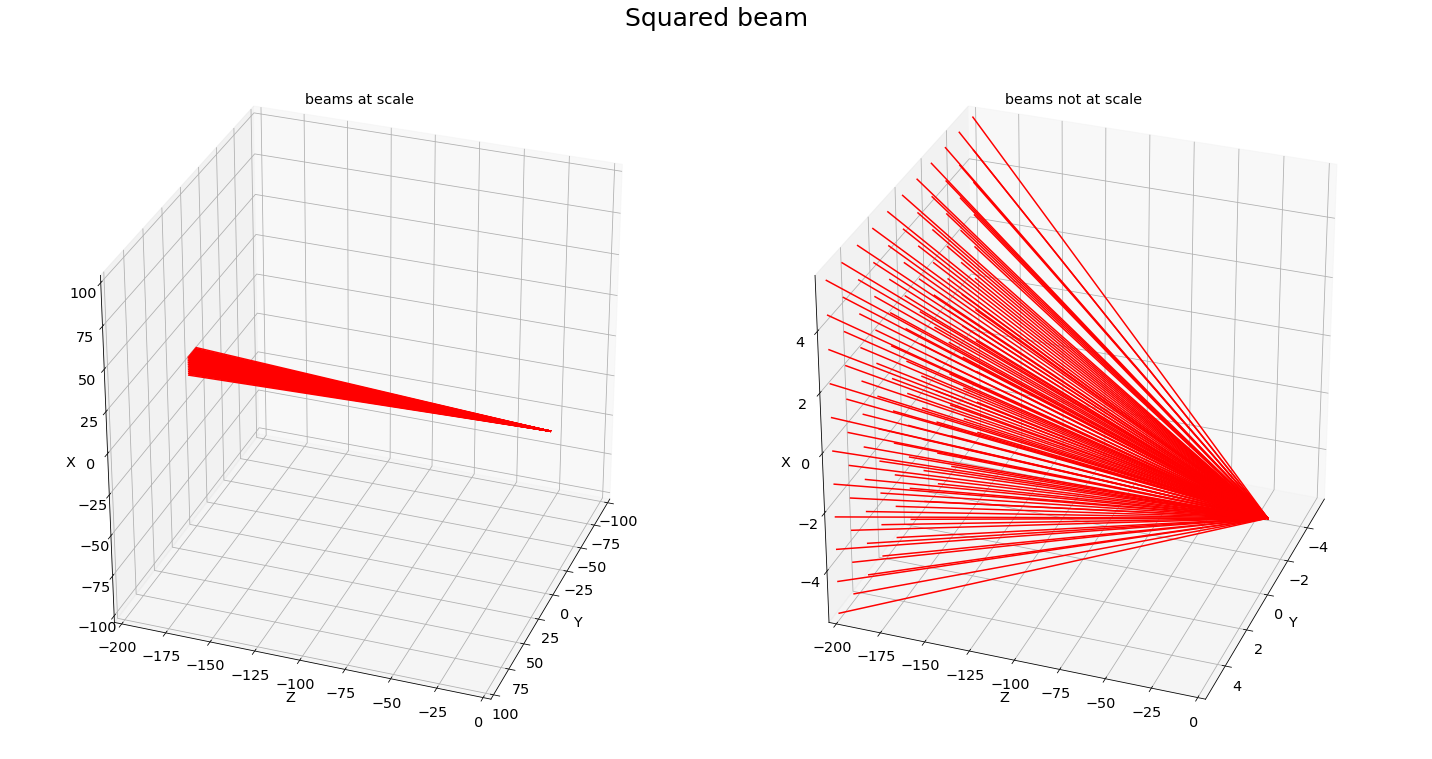

In [39]:
fig = plt.figure()
fig.set_size_inches(20,10)
#ax = fig.add_subplot(111, projection='3d', aspect='equal')
ax = fig.add_subplot(121, projection='3d')
ax.view_init(azim=20)


for i in np.arange(N):
    xs=(Y0[i],Y1[i])
    ys=(Z0[i],Z1[i])
    zs=(X0[i],X1[i])
    line = plt3d.art3d.Line3D(xs, ys, zs,color="red")
    ax.add_line(line)
    
ax.set_xlim3d(all_Y.min(), all_Y.max())
ax.set_ylim3d(all_Z.min(), all_Z.max())
ax.set_zlim3d(all_X.min(), all_X.max())
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('X')
ax.set_title('beams at scale')

set_aspect_equal_3d(ax)   


ax = fig.add_subplot(122, projection='3d')
ax.view_init(azim=20)


for i in np.arange(N):
    xs=(Y0[i],Y1[i])
    ys=(Z0[i],Z1[i])
    zs=(X0[i],X1[i])
    line = plt3d.art3d.Line3D(xs, ys, zs,color="red")
    ax.add_line(line)
    
ax.set_xlim3d(all_Y.min(), all_Y.max())
ax.set_ylim3d(all_Z.min(), all_Z.max())
ax.set_zlim3d(all_X.min(), all_X.max())
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('X')
ax.set_title('beams not at scale')

#set_aspect_equal_3d(ax) 

plt.tight_layout()
plt.suptitle("Squared beam",Y=1.05,fontsize=25)

Text(0.5, 1.05, 'Squared beam (longitudinal view)')

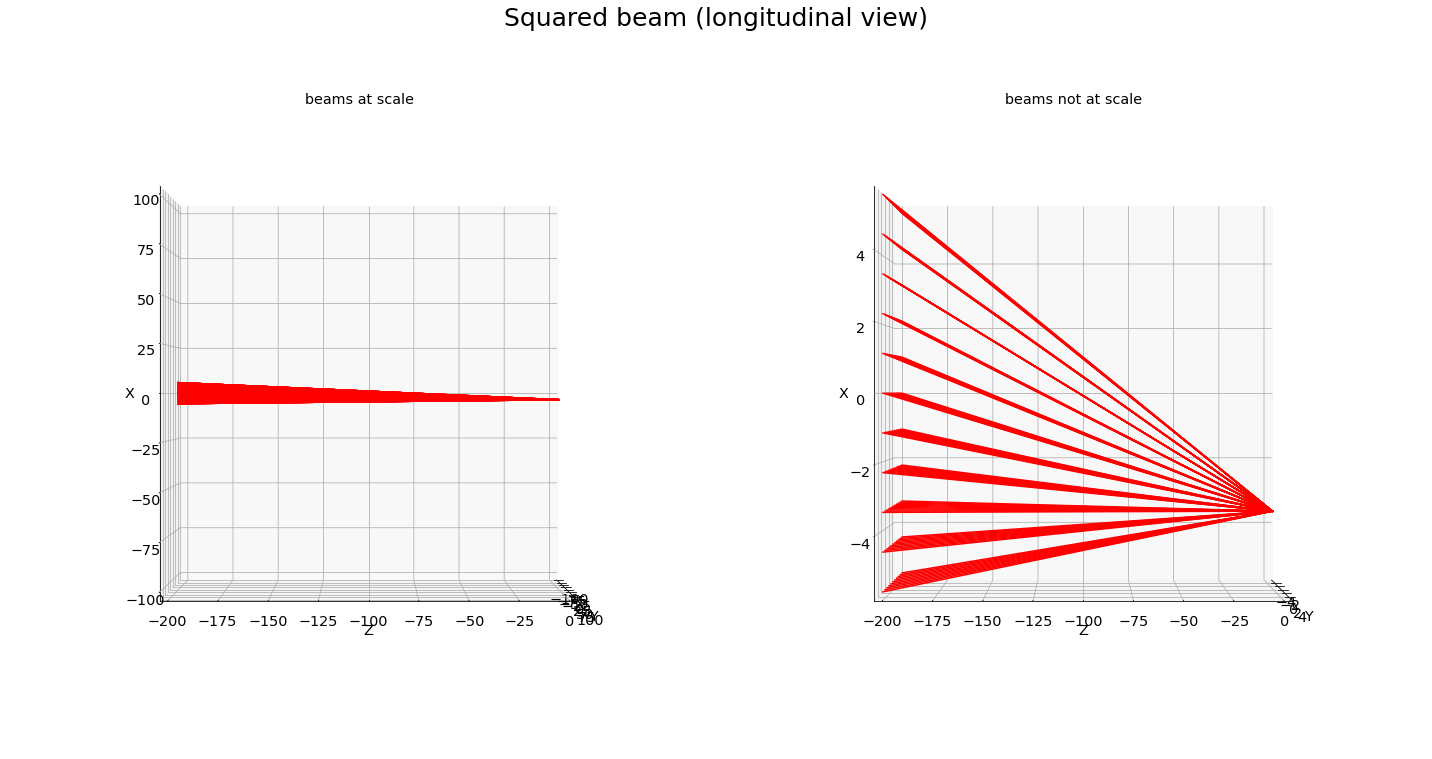

In [40]:
fig = plt.figure()
fig.set_size_inches(20,10)
#ax = fig.add_subplot(111, projection='3d', aspect='equal')
ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=0,azim=0)


for i in np.arange(N):
    xs=(Y0[i],Y1[i])
    ys=(Z0[i],Z1[i])
    zs=(X0[i],X1[i])
    line = plt3d.art3d.Line3D(xs, ys, zs,color="red")
    ax.add_line(line)
    
ax.set_xlim3d(all_Y.min(), all_Y.max())
ax.set_ylim3d(all_Z.min(), all_Z.max())
ax.set_zlim3d(all_X.min(), all_X.max())
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('X')
ax.set_title('beams at scale')

set_aspect_equal_3d(ax)   


ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=0,azim=0)


for i in np.arange(N):
    xs=(Y0[i],Y1[i])
    ys=(Z0[i],Z1[i])
    zs=(X0[i],X1[i])
    line = plt3d.art3d.Line3D(xs, ys, zs,color="red")
    ax.add_line(line)
    
ax.set_xlim3d(all_Y.min(), all_Y.max())
ax.set_ylim3d(all_Z.min(), all_Z.max())
ax.set_zlim3d(all_X.min(), all_X.max())
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('X')
ax.set_title('beams not at scale')

#set_aspect_equal_3d(ax) 

plt.tight_layout()
plt.suptitle("Squared beam (longitudinal view)",Y=1.05,fontsize=25)

# Write file with Python string Formater

In [41]:
f = open(Beam4_Rayfile_RAY, 'w')

In [42]:
def header(N,filename):
    """
    header(N,filename) : provide lines for the header of BeamFour Ray file.
    - input :
        - N : Number of beam rays
        - filename : Ray filename
    - output :
       the three header lines
    
    The width of the column must be kept fixed. The width = 12 is chosen.
    Note the : is the column separator used by BeamFour.
    
    """
    wd = ['X0', 'Y0', 'Z0','U0', 'V0', 'W0','@wave','X1', 'Y1', 'Z1','X2', 'Y2', 'Z2', 'X3', 'Y3', 'Z3','Xgoal','Ygoal','Xfinal','Yfinal','Zfinal','Notes']
    wd2 = "-----------:"
    
    
    line1 ="{:d} {}".format(N,filename)
    line1+= os.linesep
    
    line2 = ""
    Nwd=len(wd)
    
    for i in np.arange(Nwd):
        line2+=f"{wd[i]:^12}"
    line2+= os.linesep
    
    line3 = ""
    for i in np.arange(Nwd-1):
         line3+=f"{wd2:^12}"
    line3+="------------------"        
            
            
    line3+= os.linesep
        
    return line1, line2, line3

In [43]:
def GetLine(x0,y0,z0,u0,v0,w0,wa):
    """
    GetLine(x0,y0,z0,u0,v0,w0,wa) : provide the line format for each ray information.
    
    - input :
       - (x0,y0,z0) : coordinates of rays at beam entrance in mm unit
       - (u0,v0,w0) : cosinus director of rays at beam entrance
       - wa         : wavelength of the beam ray in mm
    
    - output :
       - the beam ray line.
    
    The width of the column must be kept fixed. The width = 12 is chosen.
    Note the : is the column separator used by BeamFour. The column width include the separator :
    
    """
   
    wd2 = "-----------:"
    wd0 = "           :"
    #line=f"{x0: {11.5}}:" + f"{y0: {11.5}}:" + f"{z0: {11.5}}:" + f"{u0: {11.5}}:" + f"{v0: {11.5}}:" + f"{w0: {11.5}}:" + f"{wa: {11.5}}:"
    
    line=f"{x0: {11.5}}:" + f"{y0: {11.5}}:" + f"{z0: {11}}:"+ f"{u0: {11.5}}:" + f"{v0: {11.5}}:" + f"{w0: {11.5}}:" + f"{wa: {11.6}}:"
    
    for i in np.arange(14):
        line+=wd0
        
    line+="             "
    line+= os.linesep
    
    return line

## Header

In [44]:
line1,line2,line3=header(NBEAM*NWL,Beam4_Rayfile_RAY)

In [45]:
f.write(line1)
f.write(line2)
f.write(line3)

271

## Beam rays

In [46]:
#line4 =  GetLine(df["X0"][idx],df["Y0"][idx],df["Z0"][idx],df["U0"][idx],df["V0"][idx],df["W0"][idx],wl)

In [47]:
for iwl in np.arange(NWL):
    wl=WL[iwl]*1e-6   # wavelength in mm
    for idx in np.arange(len(df)):
        line4 =  GetLine(df["X0"][idx],df["Y0"][idx],df["Z0"][idx],df["U0"][idx],df["V0"][idx],df["W0"][idx],wl)
        f.write(line4)
        

In [48]:
f.close()

In [49]:
 wd2 = "-----------:"

In [50]:
len(wd2)

12